### Prob 1: Linear Placement Version 0

We have a set of equal size boxes that are to be placed on in a linear arrangement. There is a set of nets connecting pairs of boxes. The length of a net is the difference in position between the positions assigned to its boxes. Find an order to the boxes (placement) that minimizes the sum of the net lengths. Plot the net layout for the solution as verification.

Debug and run this problem first with the following:

In [87]:
N = 6 #number of boxes
M = 7 #number of nets
net = {1: (1,2), 2: (1,4), 3: (2, 3), 4: (2, 5), 5: (2, 6), 6: (3,6), 7: (4, 5)}

## Describe the problem

* We wish to put $N$ boxes into a linear row of positions, any box may go to any position

* We want to find an arrangement of boxes such that:
    * each position contains exactly one box,
    * the nets associated with each box stretch across the placement
    * the total distance length of all nets is minimal.

## Use decision optimization

### Step 1: Import the library

Run the following code to import the Decision Optimization CPLEX Modeling library.  The *DOcplex* library contains the two modeling packages, Mathematical Programming and Constraint Programming, referred to earlier.

In [1]:
import sys
try:
    import docplex.mp
except:
    raise Exception('Please install docplex. See https://pypi.org/project/docplex/')      

If *CPLEX* is not installed, please install CPLEX Community edition.

In [2]:
try:
    import cplex
except:
    raise Exception('Please install CPLEX. See https://pypi.org/project/cplex/')

### Step 2: Model the data

The input data is the number of objects _N_, and their positions in the (x,y) plane, and the positions of the boxes.

### Step 3: Prepare the data

We use Euclidean squared distance to compute the distance between an object and its assigned box. (Since the square function in monotonic, optimizing the square distance is the same as optimizing the actual Euclidian distance (i.e. comparison results will be identical).



In [30]:
N = 6
box_ids = range(1, N+1)
pos_ids = range(1, N+1)

M = 7
net_ids = range(1, M+1)
net = {1: (1,2), 2: (1,4), 3: (2, 3), 4: (2, 5), 5: (2, 6), 6: (3,6), 7: (4, 5)}

### Step 4: Set up the prescriptive model

This is a good idea to make sure your environment is setup correctly. Your current CPLEX version is 20.1.0.0

In [31]:
from docplex.mp.environment import Environment
env = Environment()
env.print_information()

* system is: Linux 64bit
* Python version 3.8.13, located at: /home/forrest/anaconda3/envs/ece194/bin/python
* docplex is present, version is 2.23.222
* CPLEX library is present, version is 20.1.0.0, located at: /home/forrest/anaconda3/envs/ece194/lib/python3.8/site-packages/cplex-20.1.0.0-py3.8.egg
* pandas is present, version is 1.4.1


#### Create the DOcplex model
The model contains all the business constraints and defines the objective.

In [32]:
from docplex.mp.model import Model

mdl = Model(name="linear_placement0")

#### Define the decision variables

* For each box $i$ ($i$ in $0..N-1$) and pos $j$ ($j$ in $0..N-1$), we define a binary variable $X_{i,j}$ equal to $1$ if and only if pos $j$ is location of box $i$.

Note that the $name$ parameter is actually a function, this function takes a key pair $ij$ and coins a new name for each corresponding variable. The $name$ parameter also accepts a string prefix, in which case, Docplex will generate names by  concatenating the prefix with the string representation of keys. Using elaborated calls create the dictionary as a batch and is faster than creating the variables one-by-one.

In [33]:
# decision variables is a 1d-matrix
x = mdl.integer_var_dict(box_ids, lb=1, ub=N, name=lambda i: "x_%d" %(i))

#### Express the business constraints

* $X_{i}$ must contain a unique element from positions. This takes N(N-1)/2 constraints.
Printing the model information is a simple way to debug incorrect constraint or model generation. 

In [34]:
# Pos ids unique
for i in box_ids:
    for j in range(i+1,N+1):
        mdl.add_constraint(x[i]!=x[j])
    
mdl.print_information()

Model: linear_placement0
 - number of variables: 21
   - binary=15, integer=6, continuous=0
 - number of constraints: 30
   - linear=15, equiv=15
 - parameters: defaults
 - objective: none
 - problem type is: MILP


#### Express the objective

* The objective is to minimize the total distance between each object and its storage box. Note the use of the built-in dotf() method. It takes a dictionary, and a scalar function to create a dot-poduct. Note that it does not matter how nested the data is -- i.e. linear array or multiple dimension as long as the function is valid over the dictionary keys. Here, the distances are pulled from the distance array based on _x[i,j]_ == 1

In [35]:
# minimize total displacement
mdl.minimize(mdl.sum(mdl.abs(x[net[j][0]]-x[net[j][1]]) for j in net_ids))

#### Solve the model


In [36]:
mdl.print_information()

assert mdl.solve(log_output=True), "!!! Solve of the model fails"

Model: linear_placement0
 - number of variables: 49
   - binary=15, integer=6, continuous=28
 - number of constraints: 51
   - linear=36, equiv=15
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 29 rows and 29 columns.
Aggregator did 15 substitutions.
Reduced MIP has 52 rows, 50 columns, and 133 nonzeros.
Reduced MIP has 15 binaries, 6 generals, 7 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.11 ticks)
Probing time = 0.00 sec. (0.06 ticks)
Tried aggregator 2 times.
Aggregator did 15 substitutions.
Reduced MIP has 37 rows, 35 columns, and 118 nonzeros.
Reduced MIP has 15 binaries, 6 generals, 7 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.11 ticks)
Probing time = 0.00 sec. (0.02 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 37 rows, 35 columns, and 118 nonzeros.
Reduced 

In [37]:
mdl.report()
d1 = mdl.objective_value
#mdl.print_solution()

def make_solution_vector(x_vars):
    sol = [0]* N
    for i in box_ids:
        sol[i-1] = x[i].solution_value
    return sol

sol1 = make_solution_vector(x)
print("* solution: {0!s}".format(sol1))          

* model linear_placement0 solved with objective = 10.000
* solution: [2.0, 4.0, 6.0, 1.0, 3.0, 5.0]


### Step 5: Investigate the solution and then run an example analysis

Present the solution as a vector of object indices, sorted by box indices.
We use maptplotlib to display the assignment of objects to boxes.


In [38]:
try:
    import matplotlib.pyplot as plt
    from pylab import rcParams
    %matplotlib inline
    rcParams['figure.figsize'] = 12, 6
    
    def display_solution(sol):
        xs = []
        ys = []
        for j in net_ids:
            b1 = net[j][0]
            b2 = net[j][1]
            box_x1 = sol[b1-1]
            box_x2 = sol[b2-1]
            box_y = j*1.0
            plt.plot([box_x1, box_x2], [box_y, box_y])
        for i in box_ids:
            plt.text(sol[i-1]*1.0, M/2.0, str(i), bbox=dict(facecolor='red', alpha=0.5))            

except ImportError:
    print("matplotlib not found, nothing will be displayed")
    plt = None
    def display_solution(sol):   pass


The first solution shows no segments crossing, which is to be expected.

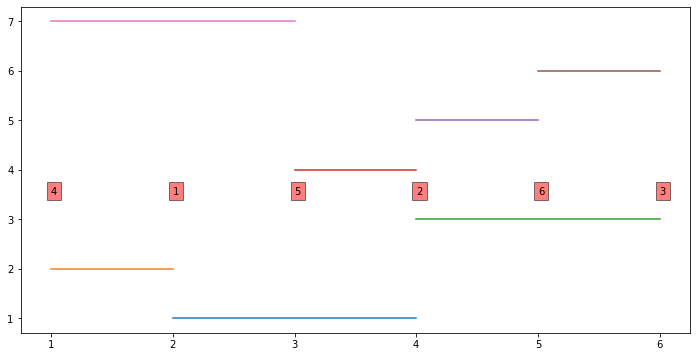

In [39]:
display_solution(sol1)

### Prob 2: Time scaling for Linear Placement 0

#### a
Measure the run time for your solution as N grows from 8,10,14,16,18,20 using randomly generated nets:
1. Each box connects to 1..4 nets with roughly equal probability for each number of connections
2. Net start and end points uniform over all boxes

In [40]:
import random as rnd
rnd.seed()
N = 12
box_ids = range(N)
net = {}
net_idx = 1
fill = [rnd.randint(1,4) for i in range(N)]
for i in range(N-1):
    while fill[i]>0 :
        done = 0
        trial = rnd.randint(i+1,N-1)
        dir = (2*rnd.randint(0,1)-1)
        for j in range(0,N-i-1):
            ntrial = i+1+(trial-i-1+dir*j)%(N-i-1)
            if fill[ntrial] > 0:
                net[net_idx] = (i, ntrial)
                fill[i] -= 1
                fill[ntrial] -= 1
                net_idx += 1
                done = 1
                break
        if done == 0 :
            break
net_ids = range(1,net_idx)
M = net_idx-1

In [41]:
from docplex.mp.model import Model

mdl2 = Model(name="linear_placement0")

In [42]:
# decision variables is a 1d-matrix
x = mdl2.integer_var_dict(box_ids, lb=0, ub=N-1, name=lambda i: "x_%d" %(i))

In [43]:
# Pos ids unique
for i in box_ids:
    for j in range(i+1,N):
        mdl2.add_constraint(x[i]!=x[j])
    
mdl2.print_information()

Model: linear_placement0
 - number of variables: 78
   - binary=66, integer=12, continuous=0
 - number of constraints: 132
   - linear=66, equiv=66
 - parameters: defaults
 - objective: none
 - problem type is: MILP


In [44]:
# minimize total displacement
mdl2.minimize(mdl2.sum(mdl2.abs(x[net[j][0]]-x[net[j][1]]) for j in net_ids))

mdl2.print_information()
print('N='+str(N)+' M='+str(M))


Model: linear_placement0
 - number of variables: 134
   - binary=66, integer=12, continuous=56
 - number of constraints: 174
   - linear=108, equiv=66
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
N=12 M=14


In [45]:
mdl2.parameters.timelimit = 100
assert mdl2.solve(log_output=True), "!!! Solve of the model fails"

Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               100
Tried aggregator 2 times.
MIP Presolve eliminated 94 rows and 94 columns.
Aggregator did 66 substitutions.
Reduced MIP has 212 rows, 172 columns, and 518 nonzeros.
Reduced MIP has 66 binaries, 12 generals, 14 SOSs, and 132 indicators.
Presolve time = 0.00 sec. (0.41 ticks)
Probing time = 0.00 sec. (0.54 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 212 rows, 172 columns, and 518 nonzeros.
Reduced MIP has 66 binaries, 78 generals, 14 SOSs, and 132 indicators.
Presolve time = 0.00 sec. (0.38 ticks)
Probing time = 0.00 sec. (0.52 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.00 sec. (0.61 ticks)

        Nodes                                         Cuts/
   Node  Left     Obje

In [46]:
mdl2.report()
d1 = mdl2.objective_value
#mdl.print_solution()

def make_solution_vector(x_vars):
    sol = [0]* N
    for i in box_ids:
        sol[i-1] = x[i].solution_value
    return sol

sol1 = make_solution_vector(x)
print("* solution: {0!s}".format(sol1))          

* model linear_placement0 solved with objective = 21.000
* solution: [7.9999999999999964, 2.0000000000000004, 3.0000000000000004, 8.999999999999996, 10.999999999999996, 0, 4.0, 5.9999999999999964, 6.9999999999999964, 5.0, 1.0, 9.999999999999996]


In [47]:
try:
    import matplotlib.pyplot as plt
    from pylab import rcParams
    %matplotlib inline
    rcParams['figure.figsize'] = 12, 6
    
    def display_solution(sol):
        xs = []
        ys = []
        for j in net_ids:
            b1 = net[j][0]
            b2 = net[j][1]
            box_x1 = sol[b1-1]
            box_x2 = sol[b2-1]
            box_y = j*1.0
            plt.plot([box_x1, box_x2], [box_y, box_y])
        for i in box_ids:
            plt.text(sol[i-1]*1.0, M/2.0, str(i), bbox=dict(facecolor='red', alpha=0.5))            

except ImportError:
    print("matplotlib not found, nothing will be displayed")
    plt = None
    def display_solution(sol):   pass


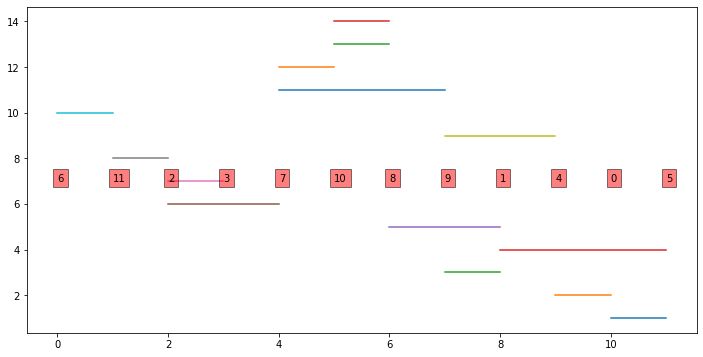

In [48]:
display_solution(sol1)

## 2b
Same scaling of N but:
1. Build Problem of size N hierarchically:
    a. divide into two sets of boxes of size N/2 as above with 1..3 random connections
    b. add N/4 random nets between the two subsets of boxes -- random positions
    
For your solution, do the 2 distributions follow the same time complexity trend?

### Prob 3: Linear Placement Version 1
This is the same problem as Version 0 except now the boxes have variable sizes. 

Debug with the following:

In [49]:
N = 10 #number of boxes
M = 14 #number of nets
net = {1: (1,2), 2: (1,4), 3: (2,3), 4: (2,8), 5: (2,7), 6: (3,6), 7: (3,7), 8: (4,5), 9:(4,10), 10:(5,7),
      11: (6,7), 12: (6,8), 13:(8,10), 14: (9,10)}
box_size = {1: 1, 2: 3, 3: 2, 4: 1, 5: 2, 6: 1, 7:3, 8:1, 9:2, 10: 4}

In [51]:
p3 = Model(name = "linear placement version 1", ignore_names=True, checker='off')

#box[i][j] = 1 if box i is in position j
b = p3.binary_var_matrix(range(0, N), range(0,N), name='b')

#one position per box
p3.add_constraints(p3.sum(b[i,j] for j in range(0,N)) == 1 for i in range(0,N))
#one box per position
p3.add_constraints(p3.sum(b[i,j] for i in range(0,N)) == 1 for j in range(0,N))

#box i is at position position[i]
positions = p3.integer_var_list(range(0,N), name='p')
p3.add_constraints((positions[i] == p3.dot((b[i,j] for j in range(0,N)), range(0,N))) for i in range(0,N))

net_start = p3.integer_var_list(range(0,M), name='ns')
net_end = p3.integer_var_list(range(0,M), name='ne')
for i in range(0,M):
    p3.add_if_then(positions[net[i+1][0] - 1] - positions[net[i+1][1] - 1] >= 0, net_start[i] == positions[net[i+1][1] - 1])
    p3.add_if_then(positions[net[i+1][0] - 1] - positions[net[i+1][1] - 1] >= 0, net_end[i] == positions[net[i+1][0] - 1])
        
    p3.add_if_then(positions[net[i+1][0] - 1] - positions[net[i+1][1] - 1] <= 0, net_start[i] == positions[net[i+1][0] - 1])
    p3.add_if_then(positions[net[i+1][0] - 1] - positions[net[i+1][1] - 1] <= 0, net_end[i] == positions[net[i+1][1] - 1])
    
#net_lengths[i][j] = 1 if box j is in between the start and end of net i
net_lengths = p3.binary_var_matrix(range(0,M), range(0,N), name='nl')
for i in range(0,M):
    for j in range(0,N):
        s = (net_start[i] + 1 <= positions[j])
        e = (net_end[i] - 1 >= positions[j])
        p3.add_if_then(s + e == 2, net_lengths[i,j] == 1)
    
net_lengths_sum = p3.integer_var_list(range(0,M), name='nls')
p3.add_constraints((net_lengths_sum[i] == p3.dot((net_lengths[i,j] for j in range(0,N)), (box_size[k+1] for k in range(0,N)))) for i in range(0,M))
        
p3.minimize(p3.sum(net_lengths_sum[i]  for i in range(0,M)))

p3s = p3.solve(clean_before_solve = True)
p3.print_solution()

In [52]:
print("objective:", int(p3s.objective_value))

#for i in range(0,M):
#    for j in range (0,N):
#        print(int(p3s.get_value(net_lengths[i,j])) * box_size[j + 1], end = " ")
#    print("")


objective: 23


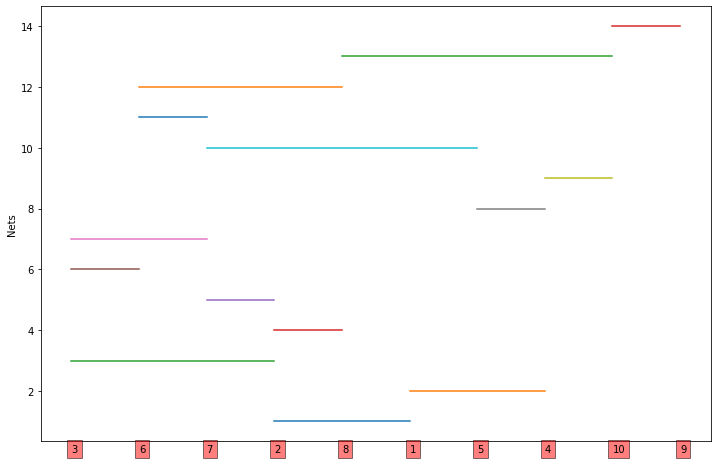

In [53]:

import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 12, 8

for i in range(0,N):
    plt.text(p3s.get_value(positions[i]),0, str(i +1), bbox=dict(facecolor='red', alpha=0.5))

for i in range(0,M):
    plt.plot([p3s.get_value(positions[net[i+1][0]-1]), p3s.get_value(positions[net[i+1][1]-1])], [i+1, i+1])

ax=plt.gca()
ax.axes.xaxis.set_visible(False)
plt.xlabel('Boxes') 
plt.ylabel('Nets') 
plt.show()